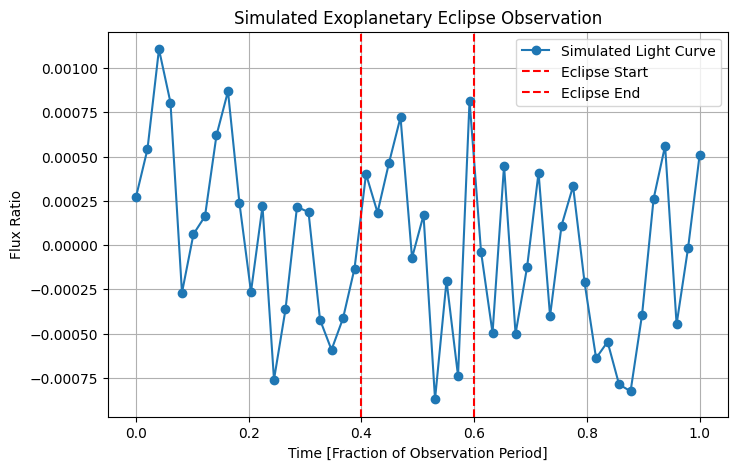

array([ 2.70766269e-04,  5.41612030e-04,  1.10687443e-03,  8.05596315e-04,
       -2.69049216e-04,  6.17822193e-05,  1.62713197e-04,  6.20167292e-04,
        8.68972257e-04,  2.35150960e-04, -2.64044483e-04,  2.19179051e-04,
       -7.60611082e-04, -3.63488863e-04,  2.15952192e-04,  1.86385106e-04,
       -4.21579844e-04, -5.92300226e-04, -4.14243817e-04, -1.32566684e-04,
        4.01177228e-04,  1.83883093e-04,  4.64998067e-04,  7.22398979e-04,
       -7.21649361e-05,  1.68948166e-04, -8.71317485e-04, -2.01304758e-04,
       -7.39508807e-04,  8.16797409e-04, -3.78115966e-05, -4.96746109e-04,
        4.49323714e-04, -5.01190863e-04, -1.25912576e-04,  4.09365860e-04,
       -4.01009271e-04,  1.10466729e-04,  3.32849999e-04, -2.11459072e-04,
       -6.39295565e-04, -5.46766959e-04, -7.87926617e-04, -8.26113119e-04,
       -3.92576762e-04,  2.61023063e-04,  5.61142470e-04, -4.47510140e-04,
       -1.54794244e-05,  5.07935476e-04])

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Functions import *

# Updated version of the simulate_eclipse_light_curve function
def simulate_eclipse_light_curve(
        T_star: float, R_star: float, Rp: float, tday: float, teff: float,
        lambda1: float, lambda2: float, throughput: float, integration_time: float,
        D_telescope: float, distance: float = 20, wavelength: float = 7.5,
        Rp_units: str = "R_jup", R_star_units: str = "R_sun",
        distance_units: str = "pc", wavelength_units: str = "um",
        eclipse_duration: float = 0.2, total_observation_time: float = 1.0,
        noise_factor: float = 1.0):
    """
    Simulate an eclipsing exoplanet light curve with a secondary eclipse.

    Args:
        T_star (float): Stellar temperature in K.
        R_star (float): Stellar radius.
        Rp (float): Planetary radius.
        tday (float): Planetary dayside emitting temperature.
        teff (float): Stellar effective temperature.
        lambda1 (float): Lower bound wavelength of observation.
        lambda2 (float): Upper bound wavelength of observation.
        throughput (float): System throughput.
        integration_time (float): Integration time per observation point.
        D_telescope (float): Diameter of telescope.
        distance (float, optional): Distance to target in parsecs. Defaults to 20.
        wavelength (float, optional): Representative wavelength. Defaults to 7.5.
        Rp_units (str, optional): Units for Rp. Defaults to "R_jup".
        R_star_units (str, optional): Units for R_star. Defaults to "R_sun".
        distance_units (str, optional): Units for distance. Defaults to "pc".
        wavelength_units (str, optional): Units for wavelength. Defaults to "um".
        eclipse_duration (float, optional): Fraction of observation time for eclipse. Defaults to 0.2.
        total_observation_time (float, optional): Total observation time. Defaults to 1.0.
        noise_factor (float, optional): Multiplicative factor for noise estimate. Defaults to 1.0.

    Returns:
        times (np.array): Array of observation times.
        fluxes (np.array): Simulated light curve fluxes.
    """

    def fluxRatio(Rp, R_star, wavelength, tday, teff, Rp_units, R_star_units, wavelength_units):
        """Returns the thermal contrast ratio with robust handling for zero/negative values."""
        radius_ratio = ((Rp * getConversion(Rp_units)) / (R_star * getConversion(R_star_units))) ** 2
        planck_function_planet = planckFunc(wavelength, tday, wavelength_units)
        planck_function_star = planckFunc(wavelength, teff, wavelength_units)
        
        # Avoid division by zero
        if planck_function_star == 0:
            planck_function_star = 1e-10
        
        return radius_ratio * (planck_function_planet / planck_function_star)

    def noiseEstimate(T_star, lambda1, lambda2, throughput, integration_time, R_star, D_telescope, distance, wavelength_units, R_star_units, distance_units):
        """Returns the noise estimate with robust handling for zero/negative values."""
        num_photons = NPhotons(T_star, lambda1, lambda2, throughput, integration_time, R_star, D_telescope, distance, wavelength_units, R_star_units, distance_units)
        
        # Avoid division by zero
        if num_photons == 0:
            num_photons = 1e-10

        return 1 / np.sqrt(num_photons)

    # Simulate time series
    num_points = int(total_observation_time / integration_time)
    times = np.linspace(0, total_observation_time, num_points)
    eclipse_start = (1.0 - eclipse_duration) / 2.0
    eclipse_end = (1.0 + eclipse_duration) / 2.0

    # Calculate signal levels
    noise_level = noise_factor * noiseEstimate(T_star, lambda1, lambda2, throughput, integration_time, R_star, D_telescope, distance, wavelength_units, R_star_units, distance_units)

    # Generate light curve
    fluxes = np.zeros(num_points)
    fluxes[(times >= eclipse_start) & (times <= eclipse_end)] = -fluxRatio(Rp, R_star, wavelength, tday, teff, Rp_units, R_star_units, wavelength_units)  # Simulate eclipse at 80% of baseline
    fluxes += np.random.normal(0, noise_level, num_points)  # Add noise

    # Plot the simulated light curve
    plt.figure(figsize=(8, 5))
    plt.plot(times, fluxes, marker='o', linestyle='-', label='Simulated Light Curve')
    plt.axvline(eclipse_start, color='r', linestyle='--', label='Eclipse Start')
    plt.axvline(eclipse_end, color='r', linestyle='--', label='Eclipse End')
    plt.xlabel("Time [Fraction of Observation Period]")
    plt.ylabel("Flux Ratio")
    plt.legend()
    plt.title("Simulated Exoplanetary Eclipse Observation")
    plt.grid(True)
    plt.show()

    return times, fluxes

# Example parameters
T_star = 3000  # Sun-like star temperature
R_star = 1.0  # Sun-like star radius in solar radii
Rp = 1.0  # Jupiter-like planet radius in Jupiter radii
a = 1.0  # Semi-major axis in AU
tday = Tday(T_star, R_star, a)  # Compute dayside temperature
lambda1, lambda2 = 0.6, 1.0  # Wavelength range in micrometers
throughput = 0.3  # Example system throughput
integration_time = 0.02  # Integration time per point (fraction of observation period)
D_telescope = 6.5  # Diameter of telescope in meters (e.g., JWST)
distance = 10  # Distance to the system in parsecs
total_observation_time = 1.0  # Fractional observation period
eclipse_duration = 0.2  # Fractional eclipse duration

# Simulate the light curve
times, fluxes = simulate_eclipse_light_curve( 
    T_star=T_star, R_star=R_star, Rp=Rp, tday=tday, teff=T_star,
    lambda1=lambda1, lambda2=lambda2, throughput=throughput, 
    integration_time=integration_time, D_telescope=D_telescope,
    distance=distance, wavelength=7.5, total_observation_time=total_observation_time,
    eclipse_duration=eclipse_duration
)

fluxes

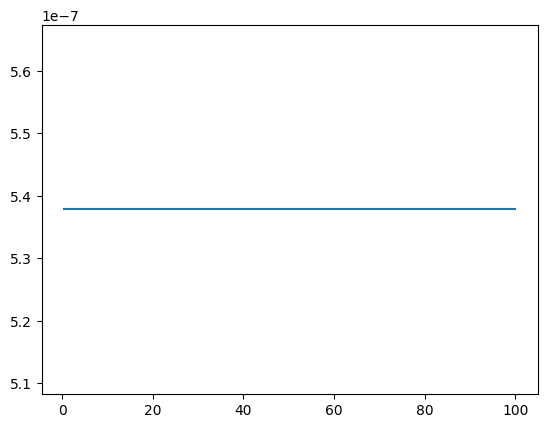

In [2]:
temperature=5000
bound1=1.0
bound2=4.0
tao=0.40
int_time=3600 #in seconds
R_star=0.75
D=6.5
d=20
a=0.018
Rp=1.10

wavelengths = np.linspace(0.5,100, 100)

arr = []
for wavelength in wavelengths:
    arr.append(noiseEstimate(temperature, bound1, bound2, tao, int_time, R_star, D, d))
    
plt.plot(wavelengths, arr)